# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

(5000, 30, 8)
data x shape: (5000, 30, 8)
data y shape: (5000, 30, 1)


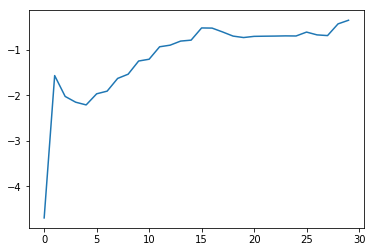

In [6]:
BATCH_SIZE=5000
TIME_SERIES_LENGTH = 30

def g1(x):
    return 1/(np.e * (x+0.023))

def g2(x):
    return -1/(x+0.02)

def g3(x):
    return 1/(x + 1.7)

def g4(x):
    return 3

def g5(x):
    return -1

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, g1, g2, g3, g4, g5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, func_count + 1))
    y_data = np.zeros((batch_size, time_series_length, 1))
    y_prev = 0
    
    for batch_idx in range(batch_size):
        x = np.zeros((time_series_length, func_count+1), dtype=np.float16)
        y = np.zeros((time_series_length, 1))
        for t in range(time_series_length):
            selected_func_idx = np.random.randint(func_count)
            
            x[t, 0] = t/time_series_length
            x[t, selected_func_idx + 1] = 1
            
            y_pred = funcs[selected_func_idx](t)
            y[t, 0] = y_pred + (y_prev * 0.3)
            y_prev = y[t, 0]
            
        y = np.cumsum(y, axis=0)
        y[moving_avg_n:] = y[moving_avg_n:] - y[:moving_avg_n]
        y = y[moving_avg_n-1:] / moving_avg_n
                
        x_data[batch_idx, :] = x
        y_data[batch_idx, :] = y
      
    print(x_data.shape)    
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)

# Scaling
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)
plot(data_y[0])

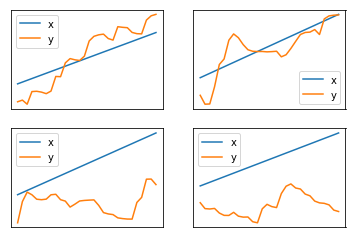

In [7]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
            sample_y = data_y[batch_idx]
                                    
            sample_x = sample_x[:, 0].reshape((-1, 1))
            
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x, label='x')
            sp.plot(tick_x, sample_y, label='y')
            sp.legend()

visualize(data_x, data_y)

## Model

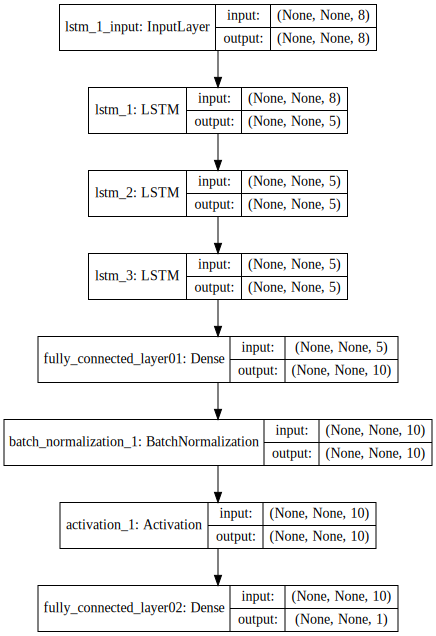

In [8]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, 8), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [ ]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return scoreepochs

# Grid Search 
params = dict(lstm_out1=[1, 4, 6, 10, 20, 50, 100], 
              lstm_out2=[None, 4, 6, 10, 20, 100], 
              lstm_out3=[None, 4, 6, 10, 20, 100], 
              optimizer=['adam'], 
              nb_epoch=[30, 200])

classifier = KerasRegressor(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer, n_jobs=1)
grid_result = grid.fit(X=data_x, y=data_y)

error:0.9311342615786549, score:0.07817997538455923
error:0.9163804572449392, score:0.07895236105238568
error:0.31095936531420015, score:0.6801578204652571
error:0.3107998050428667, score:0.6934531949317241
error:0.34206862551535344, score:0.663860378094901
error:0.3382513206735442, score:0.6587407854169831
error:0.8693935414821076, score:0.13930309636464433
error:0.8558105224767423, score:0.1398307822020276
error:0.36614872148160454, score:0.6233919342027032
error:0.36273071819238933, score:0.6422329069779764
error:0.21431603757455653, score:0.7893986572724221
error:0.20435610607659627, score:0.7938266608506478
error:1.880101080065185, score:-0.8612942251387726
error:1.8749547133368079, score:-0.8845039723397102
error:0.7633453886800038, score:0.21484901216429575
error:0.7635848848194091, score:0.24686404868390166
error:0.7523866886643324, score:0.26065427171803945
error:0.7433186157156981, score:0.2500714365905078
error:1.8072063181948788, score:-0.7891286374740059
error:1.8172515786

In [ ]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

## Training

In [9]:
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

Epoch 1/300
9s - loss: 0.6014 - mean_squared_error: 0.6014
Epoch 2/300
8s - loss: 0.4307 - mean_squared_error: 0.4307
Epoch 3/300
7s - loss: 0.2862 - mean_squared_error: 0.2862
Epoch 4/300
8s - loss: 0.2081 - mean_squared_error: 0.2081
Epoch 5/300
8s - loss: 0.1401 - mean_squared_error: 0.1401
Epoch 6/300
8s - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 7/300
8s - loss: 0.0869 - mean_squared_error: 0.0869
Epoch 8/300
7s - loss: 0.0760 - mean_squared_error: 0.0760
Epoch 9/300
8s - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 10/300
8s - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 11/300
7s - loss: 0.0712 - mean_squared_error: 0.0712
Epoch 12/300
7s - loss: 0.0631 - mean_squared_error: 0.0631
Epoch 13/300
7s - loss: 0.0607 - mean_squared_error: 0.0607
Epoch 14/300
8s - loss: 0.0557 - mean_squared_error: 0.0557
Epoch 15/300
8s - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 16/300
8s - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 17/300
8s - loss: 0.0501 - mean_squared_err

7s - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 138/300
7s - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 139/300
8s - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 140/300
7s - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 141/300
8s - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 142/300
8s - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 143/300
8s - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 144/300
8s - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 145/300
8s - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 146/300
7s - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 147/300
8s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 148/300
8s - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 149/300
8s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 150/300
8s - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 151/300
7s - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 152/300
8s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 153/300
7s - loss: 0.0182 - mean

8s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 273/300
8s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 274/300
8s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 275/300
8s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 276/300
8s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 277/300
7s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 278/300
8s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 279/300
8s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 280/300
8s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 281/300
7s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 282/300
8s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 283/300
7s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 284/300
7s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 285/300
8s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 286/300
8s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 287/300
8s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 288/300
8s - loss: 0.0027 - mean

error:0.011746012784368575, score:0.9882539872156314
score: 0.988253987216


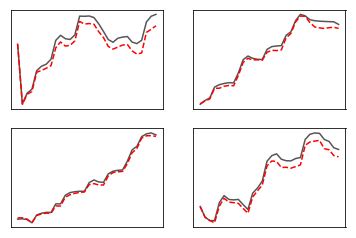

In [10]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')
            

visualize_prediction(data_x, data_y)

# Test

### test1

```
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

error:0.01373816696803562, score:0.9862618330319642
score: 0.986261833032
```